In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def image_sharpness(frame):
    F = np.fft.fft2(frame)

    Fc = np.fft.fftshift(F)

    AF = np.abs(Fc)

    M = np.max(AF)

    Th = np.sum(AF > (M / 1000))

    return Th / (frame.shape[0] * frame.shape[1])

In [12]:
video_path = './data/focus_video.mov'
cap = cv2.VideoCapture(video_path)
fm_scores = []

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        fm_scores.append(image_sharpness(gray_frame))

    else:
        break

cap.release()

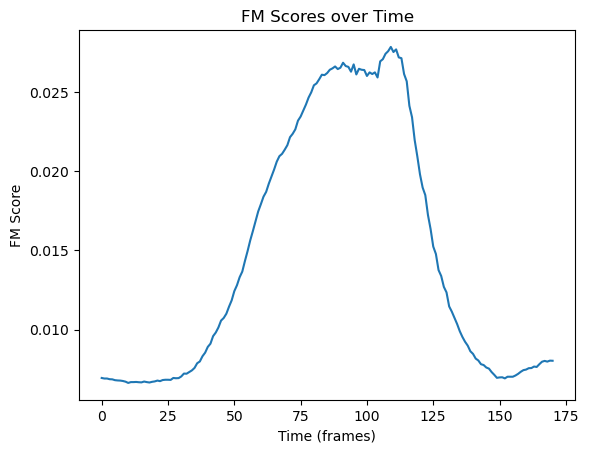

In [13]:
plt.plot(fm_scores)
plt.xlabel('Time (frames)')
plt.ylabel('FM Score')
plt.title('FM Scores over Time')
plt.show()

In [19]:
def plot_img(img):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 1, 1)
    plt.imshow(img)
    plt.axis('off')

    plt.show()

In [14]:
def roi_grid(frame, grid_size=(8, 8), roi_size=20):
    output_image = frame.copy()
    spacing = 20

    total_grid_width = grid_size[1] * roi_size + (grid_size[1] - 1) * spacing
    total_grid_height = grid_size[0] * roi_size + (grid_size[0] - 1) * spacing

    img_height, img_width = frame.shape[:2]
    start_x = (img_width - total_grid_width) // 2
    start_y = (img_height - total_grid_height) // 2

    rois = []

    for row in range(grid_size[0]):
        for col in range(grid_size[1]):
            x = start_x + col * (roi_size + spacing)
            y = start_y + row * (roi_size + spacing)

            top_left = (x, y)
            bottom_right = (x + roi_size, y + roi_size)

            rois.append(frame[y:y + roi_size, x:x + roi_size])
            cv2.rectangle(output_image, top_left, bottom_right, (0, 255, 0), 2)

    return rois, output_image

In [23]:
video_path = './data/focus_video.mov'
cap = cv2.VideoCapture(video_path)
fm_scores = []
frames = []

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        # Single ROI, 6.25 % of image size ((120 * 120) / (360 * 640))
        rois = roi_grid(frame, (1,1), 120)
        frames.append(rois[1])
        fm_scores.append(image_sharpness(rois[0][0]))

    else:
        break

cap.release()
cv2.destroyAllWindows()

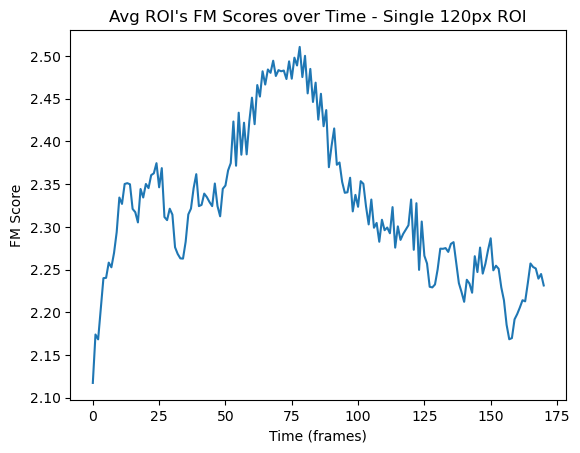

In [29]:
plt.plot(fm_scores)
plt.xlabel('Time (frames)')
plt.ylabel('FM Score')
plt.title('Avg ROI\'s FM Scores over Time - Single 120px ROI')
plt.show()

In [31]:
video_path = 'data/focus_video.mov'
cap = cv2.VideoCapture(video_path)
fm_scores = []

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        # Default grid, 8x8 20px squares
        rois = roi_grid(frame)[0]
        fm_scores.append(np.mean([image_sharpness(roi) for roi in rois]))

    else:
        break

cap.release()
cv2.destroyAllWindows()

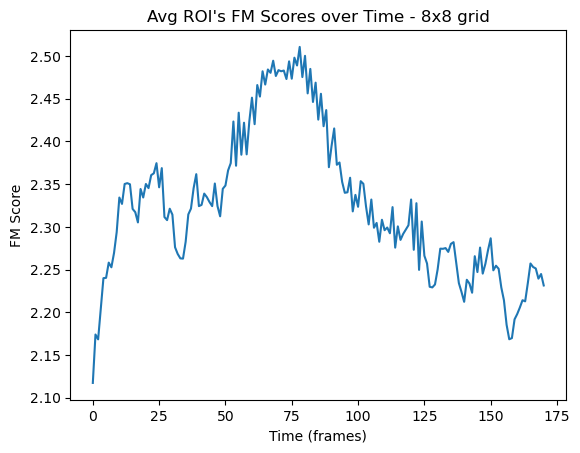

In [32]:
plt.plot(fm_scores)
plt.xlabel('Time (frames)')
plt.ylabel('FM Score')
plt.title('Avg ROI\'s FM Scores over Time - 8x8 grid')
plt.show()